In [1]:
import os
import pandas as pd
from datetime import datetime, timedelta
import movingpandas as mpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from common import get_shark_gdf, wrap_to_pi
from tensorflow_probability import distributions as tfd

In [2]:
# Input and output variables
output = "../graphs"
# filepath = "../data/2020-21/2020-21-max-3-min-run.csv"
filepath = "../data/2020-21/2020-21-477-long-15-min-run.csv"
filename = os.path.splitext(os.path.basename(filepath))[0]
savepath = os.path.normpath(os.path.join(output, filename))
if not os.path.isdir(savepath):
    os.mkdir(savepath)

In [3]:
def add_columns(traj):
    # Add a timedelta column
    n = traj.df.shape[0]
    timedeltas = [timedelta()] + [traj.df.index[i] - traj.df.index[i - 1] for i in range(1, n)]
    traj.df['TIMEDELTA'] = timedeltas

    # Add velocities and headings to each trajectory
    traj.add_speed()
    traj.add_direction()

    # Compute turning angles
    def bound_angle_diff(theta_diff):
        return (180 / np.pi) * wrap_to_pi(theta_diff * (np.pi / 180))
    turning_angles = [0] + [bound_angle_diff(traj.df['direction'][i + 1] - traj.df['direction'][i]) for i in range(1, n - 1)] + [0]
    traj.df['turning_angle'] = turning_angles

In [4]:
# Get data
shark_gdf = get_shark_gdf(filepath)
traj = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER').trajectories[0]
add_columns(traj)

<AxesSubplot:>

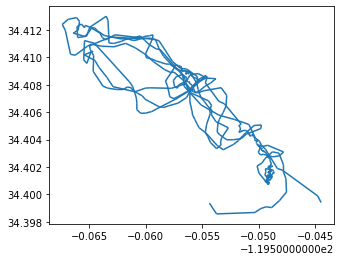

In [5]:
# Plot trajectory
traj.plot(linestyle='None')

In [6]:
# Create a random number generator
rng = np.random.default_rng()

Text(0, 0.5, 'counts')

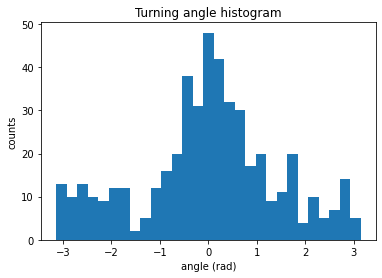

In [7]:
# Plot turning angles
turning_angles = wrap_to_pi(np.radians(np.array(traj.df['turning_angle'])))
plt.hist(turning_angles, bins=np.linspace(-np.pi, np.pi, 30))
plt.title('Turning angle histogram')
plt.xlabel('angle (rad)')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

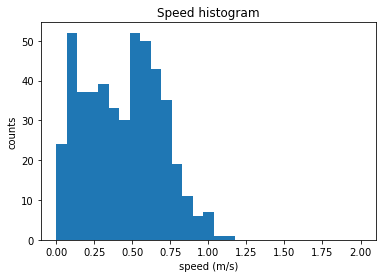

In [8]:
# Plot speeds
speeds = np.array(traj.df['speed'])
plt.hist(speeds, bins=np.linspace(0, np.ceil(np.max(speeds)), 30))
plt.title('Speed histogram')
plt.xlabel('speed (m/s)')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

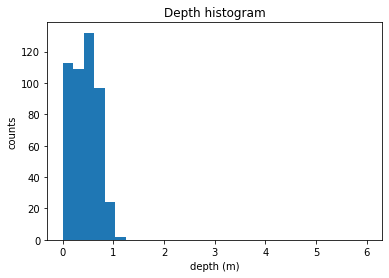

In [9]:
depths = np.array(traj.df['DEPTH'])[1:]
plt.hist(speeds, bins=np.linspace(0, np.ceil(np.max(depths)), 30))
plt.title('Depth histogram')
plt.xlabel('depth (m)')
plt.ylabel('counts')

In [10]:
observations = []
observations.append(turning_angles)
observations.append(speeds)
observations = np.array(observations).T
num_observations = len(observations)

In [11]:
# Determine the number of states and covariates for the model
num_states = 2
num_covariates = 1

In [12]:
# Randomly initialize the initial state distribution and the regression coefficients for the transition probabilities
initial_logits = tf.Variable(rng.random([num_states]), name='initial_logits', dtype=tf.float32)
initial_distribution = tfd.Categorical(logits=initial_logits)
print(initial_logits)

<tf.Variable 'initial_logits:0' shape=(2,) dtype=float32, numpy=array([0.13323426, 0.7753825 ], dtype=float32)>


In [13]:
# Create the regression coefficients and put together the covariates
regression_weights = tf.Variable(rng.random([num_covariates, num_states, num_states]) * (1 - np.diag([1] * num_states)), name='regression_weights', dtype=tf.float32)
regression_biases = tf.Variable(rng.random([1, num_states, num_states]) * (1 - np.diag([1] * num_states)), name='regression_biases', dtype=tf.float32)
# covariates = rng.random([num_observations - 1, num_covariates, 1, 1])
# regression_coeffs = tf.Variable(rng.random([num_covariates + 1, num_states, num_states]) * (1 - np.diag([1] * num_states)), name='regression_coeffs', dtype=tf.float32)
# covariates = rng.random([num_observations - 1, num_covariates])
# print(regression_weights)
# print(regression_biases)
# print(covariates)
print(regression_weights)
print(regression_biases)

<tf.Variable 'regression_weights:0' shape=(1, 2, 2) dtype=float32, numpy=
array([[[0.        , 0.44710463],
        [0.6740631 , 0.        ]]], dtype=float32)>
<tf.Variable 'regression_biases:0' shape=(1, 2, 2) dtype=float32, numpy=
array([[[0.        , 0.10283394],
        [0.76338804, 0.        ]]], dtype=float32)>


In [14]:
covariates = np.array([depths]).reshape(num_observations - 1, num_covariates, 1, 1)

In [15]:
# np.ones([3, 5, 5]) * np.array([[[2]], [[3]], [[4]]])
# tf.reduce_sum(tf.constant(rng.random([num_covariates, num_states, num_states])) * tf.constant(rng.random([num_covariates, 1, 1])), axis=0)
# np.ones([2, 3, 3]) * np.ones([4, 2, 1, 1])
# tf.reduce_sum(tf.constant(rng.random([num_covariates, num_states, num_states])) * tf.constant(rng.random([num_observations, num_covariates, 1, 1])), axis=1) + np.ones([num_states, num_states])
# np.ones([3, 4, 4]) * np.array([[[[1]], [[2]], [[3]]],
#                                [[[4]], [[5]], [[6]]],
#                                [[[7]], [[8]], [[9]]],
#                                [[[10]], [[11]], [[12]]]])
# tf.reduce_sum(regression_weights * covariates, axis=1) + regression_biases

In [16]:
# Compute the transition logits for each time step
def get_transition_logits():
    return tf.reduce_sum(regression_weights * covariates, axis=1) + regression_biases
#     logits = []
#     for i in range(num_observations - 1):
#         logits.append(
#             regression_coeffs[0] + 
#             tf.reduce_sum(
#                 regression_coeffs[1:] * covariates[i].reshape(num_covariates, 1, 1),
#                 axis=0))
#     return np.array(logits)

#     transition_probs.append(logit_link(tlo))
# transition_distribution = tfd.Categorical(logits=transition_logits)

In [17]:
dists = []

# Initialize locations and concentrations of Von Mises distributions for turning angles
vm_locs = tfp.util.TransformedVariable(
    initial_value=np.zeros(num_states, dtype=np.float32),
    bijector=tfp.bijectors.Sigmoid(low=-np.pi, high=np.pi),
    name='vm_locs')

vm_cons = tfp.util.TransformedVariable(
    initial_value=np.zeros(num_states, dtype=np.float32) + 1e-2,
    bijector=tfp.bijectors.Softplus(low=1e-3),
    name='vm_locs')

dists.append(tfd.VonMises(loc=vm_locs, concentration=vm_cons))
print(vm_locs)
print(vm_cons)

<TransformedVariable: dtype=float32, shape=[2], fn="sigmoid", numpy=array([0., 0.], dtype=float32)>
<TransformedVariable: dtype=float32, shape=[2], fn="softplus", numpy=array([0.01, 0.01], dtype=float32)>


In [18]:
# Initialize shapes and rates of Gamma distributions for step length
gamma_shapes = tfp.util.TransformedVariable(
    initial_value=np.ones(num_states, dtype=np.float32),
    bijector=tfp.bijectors.Softplus(low=1e-3),
    name='gamma_shapes')

gamma_rates = tfp.util.TransformedVariable(
    initial_value=np.ones(num_states, dtype=np.float32),
    bijector=tfp.bijectors.Softplus(low=1e-3),
    name='gamma_shapes')

dists.append(tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates))
print(gamma_shapes)
print(gamma_rates)

<TransformedVariable: dtype=float32, shape=[2], fn="softplus", numpy=array([1., 1.], dtype=float32)>
<TransformedVariable: dtype=float32, shape=[2], fn="softplus", numpy=array([1., 1.], dtype=float32)>


In [19]:
joint_dists = tfd.Blockwise(dists)

In [20]:
hmm = None

# Define a loss function
def compute_loss():
    global hmm
    hmm = tfd.HiddenMarkovModel(
        initial_distribution = initial_distribution,
        transition_distribution = tfd.Categorical(logits=get_transition_logits()),
        observation_distribution = joint_dists,
        num_steps = num_observations,
        time_varying_transition_distribution = True
    )
    return -tf.reduce_logsumexp(hmm.log_prob(observations))

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(rtol=0.01)

def trace_fn(traceable_quantities):
    regression_weights.assign(regression_weights * (1 - np.diag([1] * num_states)))
    regression_biases.assign(regression_biases * (1 - np.diag([1] * num_states)))
    return traceable_quantities.loss

In [21]:
loss_history = tfp.math.minimize(
    loss_fn=compute_loss,
    num_steps=1000,
    optimizer=optimizer,
    convergence_criterion=criterion,
    trace_fn=trace_fn)

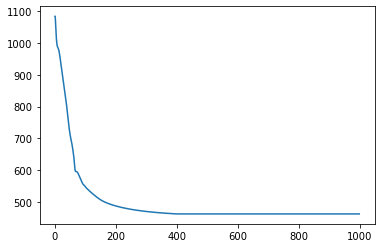

In [22]:
plt.plot(loss_history)

In [23]:
# Create the hmm with all of its trained values
hmm = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = tfd.Categorical(logits=get_transition_logits()),
    observation_distribution = joint_dists,
    num_steps = num_observations,
    time_varying_transition_distribution = True
)

In [24]:
print(regression_weights)
print(regression_biases)

<tf.Variable 'regression_weights:0' shape=(1, 2, 2) dtype=float32, numpy=
array([[[-0.       ,  0.5539767],
        [ 0.7413567,  0.       ]]], dtype=float32)>
<tf.Variable 'regression_biases:0' shape=(1, 2, 2) dtype=float32, numpy=
array([[[-0.       , -5.0029416],
        [-5.5573263, -0.       ]]], dtype=float32)>


In [25]:
transition_logits = get_transition_logits()
transition_probs = tf.exp(transition_logits) / tf.reshape(tf.reduce_sum(tf.exp(transition_logits), axis=2), [num_observations - 1, 2, 1])
# print(transition_probs)

tf.Tensor(
[[[0.96522087 0.03477912]
  [0.03524308 0.96475697]]

 [[0.98900324 0.01099673]
  [0.00751685 0.9924831 ]]

 [[0.9880513  0.01194864]
  [0.00840346 0.9915965 ]]

 ...

 [[0.993327   0.00667296]
  [0.00384396 0.99615604]]

 [[0.86939627 0.13060378]
  [0.19797762 0.8020224 ]]

 [[0.9858969  0.01410318]
  [0.01049928 0.9895007 ]]], shape=(476, 2, 2), dtype=float32)


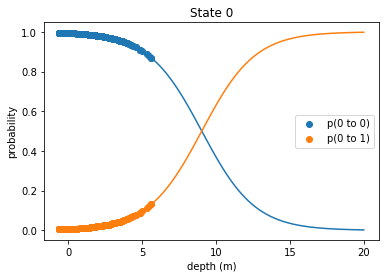

In [63]:
x = np.linspace(0, 20, 1000)
log_odds = regression_weights[0, 0, 1] * x + regression_biases[0, 0, 1]
y = np.exp(log_odds)
y = y / (1 + y)
plt.plot(x, 1 - y)
plt.plot(x, y)
plt.scatter(depths, transition_probs[:, 0, 0], label='p(0 to 0)')
plt.scatter(depths, transition_probs[:, 0, 1], label='p(0 to 1)')
plt.xlabel('depth (m)')
plt.ylabel('probability')
plt.title('State 0')
plt.legend()

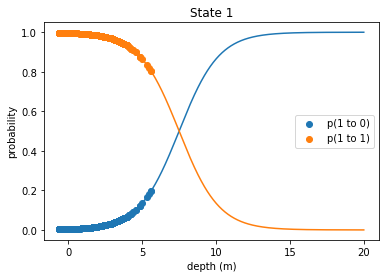

In [64]:
# plt.scatter(depths, transition_probs[:, 1, 1])
x = np.linspace(0, 20, 1000)
log_odds = regression_weights[0, 1, 0] * x + regression_biases[0, 1, 0]
y = np.exp(log_odds)
y = y / (1 + y)
plt.plot(x, y)
plt.plot(x, 1 - y)
plt.scatter(depths, transition_probs[:, 1, 0], label='p(1 to 0)')
plt.scatter(depths, transition_probs[:, 1, 1], label='p(1 to 1)')
plt.xlabel('depth (m)')
plt.ylabel('probability')
plt.title('State 1')
plt.legend()

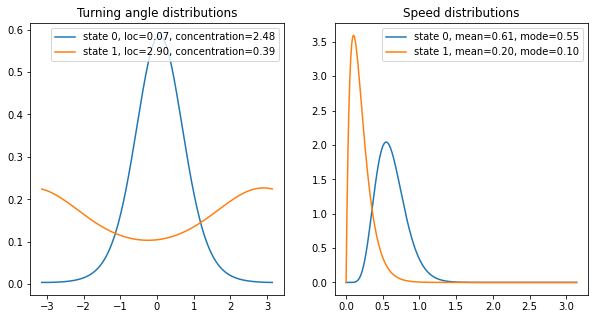

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot observation distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
for (j, (obs_dist, ax)) in enumerate(zip(hmm.observation_distribution.distributions, axs)):
    y = obs_dist.prob(x).numpy()
    for i in range(y.shape[1]):
        if j == 0:
            label = 'state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i])
            title = 'Turning angle distributions'
        else:
            label = 'state {}, mean={:.2f}, mode={:.2f}'.format(i, gamma_shapes[i] / gamma_rates[i], (gamma_shapes[i] - 1) / gamma_rates[i])
            title = 'Speed distributions'
        ax.plot(x[:, 0], y[:, i], label=label)
        ax.set_title(title)
        ax.legend(loc='upper right')
plt.show()

In [29]:
posterior_dists = hmm.posterior_marginals(np.array([turning_angles, speeds]).T)
posterior_probs = posterior_dists.probs_parameter().numpy()

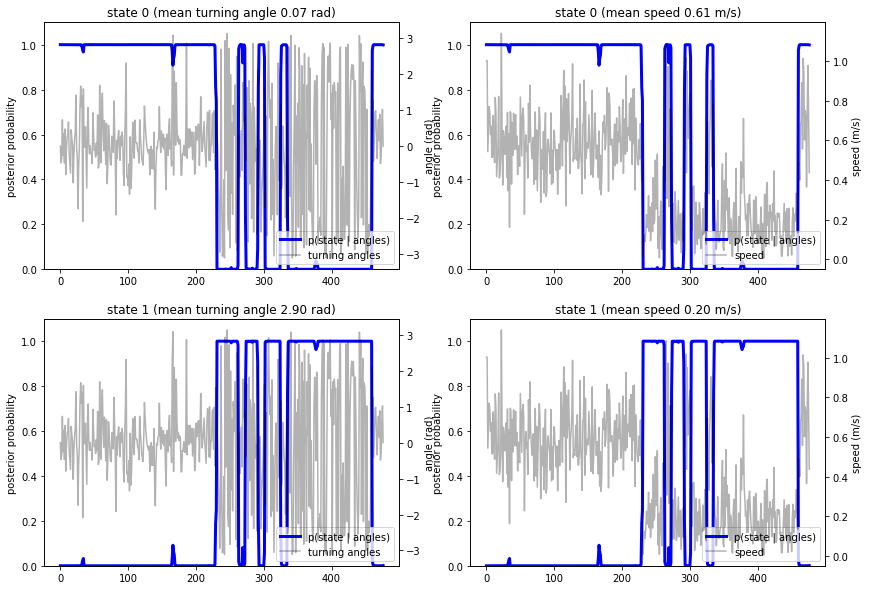

In [30]:
def plot_state_posterior(ax, state_posterior_probs, observed_data, title, label='turning angles', ylabel='angle (rad)'):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | angles)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_data, c='black', alpha=0.3, label=label)
    ax2.set_title(title)
    ax2.set_ylabel(ylabel)
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)

fig, axs = plt.subplots(num_states, 2, figsize=(14, 5 * num_states))
for state, ax_row in enumerate(axs):
    for i, ax in enumerate(ax_row):
        if i == 0:
            plot_state_posterior(ax, posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))
        else:
            plot_state_posterior(ax, posterior_probs[:, state], speeds, 'state {} (mean speed {:.2f} m/s)'.format(state, gamma_shapes[state] / gamma_rates[state]), label='speed', ylabel='speed (m/s)')

Text(0.5, 1.0, 'Trajectory with states')

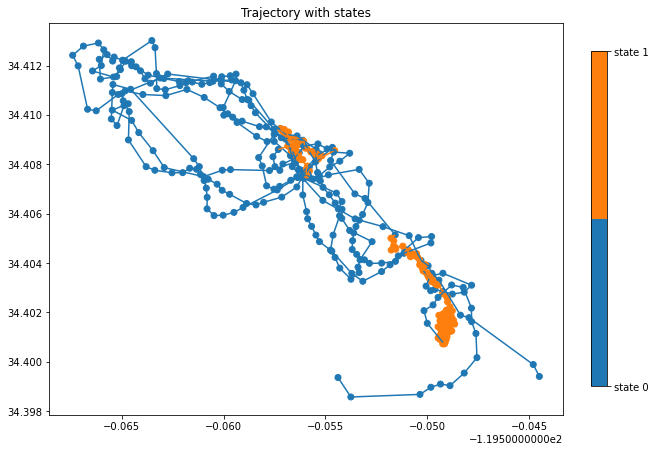

In [31]:
x = [point.coords[0][0] for point in traj.df['geometry']]
y = [point.coords[0][1] for point in traj.df['geometry']]
fig, ax = plt.subplots(figsize=(10, 10))
cmaplist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:num_states]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, num_states)
color = np.argmax(posterior_probs, axis=1)
sc = ax.scatter(x, y, c=color, cmap=cmap)
traj.df['state'] = color
traj.plot(ax=ax, marker='o', column='state', cmap=cmap)
ticks = np.array(list(range(num_states)))
tick_labels = ['state {}'.format(i) for i in range(num_states)]
cbar = plt.colorbar(sc, fraction=0.03)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.title('Trajectory with states')